# Part 1: Building up a basic predictive model

In [195]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import scatter_matrix

## Task 1 : Data Cleaning and Transformation

In [197]:
df = pd.read_csv('Dataset.csv') #Loading the dataset

In [198]:
# inspecting the data
df.head()

,index,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,2,1,2,2,09/06/2020,1,2,55,?,...,2,2,2,2,2,2,2,2,3,2.0
1,5,2,1,1,2,9999-99-99,2,1,40,2,...,2,2,2,2,2,2,2,2,3,2.0
2,8,2,1,1,2,9999-99-99,2,2,37,2,...,2,2,1,2,2,1,2,2,3,2.0
3,9,2,1,1,2,9999-99-99,2,2,25,2,...,2,2,2,2,2,2,2,2,3,2.0
4,11,2,1,2,2,9999-99-99,2,2,24,?,...,2,2,2,2,2,2,2,2,3,2.0


In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200031 entries, 0 to 200030
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   index                 200031 non-null  int64 
 1   USMER                 200031 non-null  int64 
 2   MEDICAL_UNIT          200031 non-null  int64 
 3   SEX                   200031 non-null  int64 
 4   PATIENT_TYPE          200031 non-null  int64 
 5   DATE_DIED             200031 non-null  object
 6   INTUBED               200031 non-null  object
 7   PNEUMONIA             200031 non-null  object
 8   AGE                   200031 non-null  int64 
 9   PREGNANT              200031 non-null  object
 10  DIABETES              200031 non-null  object
 11  COPD                  200031 non-null  object
 12  ASTHMA                200031 non-null  object
 13  INMSUPR               200031 non-null  object
 14  HIPERTENSION          200031 non-null  object
 15  OTHER_DISEASE    

### Check dataset shape

In [201]:
print(f"Initial Dataset Shape: {df.shape}") #Checking dataset shape

Initial Dataset Shape: (200031, 22)


### Remove irrelevent columns

In [203]:
# Changing '?' to NaN
df.replace('?', np.nan, inplace=True)

# Changing '9999-99-99' in DATE_DIED to NaN 
df.loc[df['DATE_DIED'] == '9999-99-99', 'DATE_DIED'] = np.nan

# Converting ICU to numeric for handling mixed types
df['ICU'] = pd.to_numeric(df['ICU'], errors='coerce')

In [204]:
# Identifying missing values before handling
missing_values_before = df.isnull().sum()
print(missing_values_before)

index                        0
USMER                        0
MEDICAL_UNIT                 0
SEX                          0
PATIENT_TYPE                 0
DATE_DIED               129965
INTUBED                   7325
PNEUMONIA                 5144
AGE                          0
PREGNANT                118792
DIABETES                  1195
COPD                      1064
ASTHMA                    1066
INMSUPR                   1280
HIPERTENSION              1106
OTHER_DISEASE             2074
CARDIOVASCULAR            1143
OBESITY                   1113
RENAL_CHRONIC             1074
TOBACCO                   1126
CLASIFFICATION_FINAL         0
ICU                       7488
dtype: int64


In [205]:
# Remove irrelevant columns
# 'index' is dropped as it does not contribute to analysis
df.drop(columns=['index'], errors='ignore', inplace=True)

#irrelevant_columns = ["patient_id", "timestamp"]
#df.drop(columns=irrelevant_columns, inplace=True, errors='ignore')

In [206]:
#handles missing values in the PREGNANT column by setting it to 0 for males, 
#then either dropping or imputing it for females based on missing value proportion 
if 'PREGNANT' in df.columns:
    # Set PREGNANT = 0 for males (SEX == 1)
    df.loc[df['SEX'] == 1, 'PREGNANT'] = 0  

    # Check missing percentage only for females
    female_missing_ratio = df.loc[df['SEX'] == 2, 'PREGNANT'].isna().mean()
    
    # Drop PREGNANT if too many missing values in females
    if female_missing_ratio > 0.5:
        df.drop(columns=['PREGNANT'], inplace=True)
    else:
        # Fill missing PREGNANT values for females with mode
        female_mode = df.loc[df['SEX'] == 2, 'PREGNANT'].mode()
        if not female_mode.empty:
            df.loc[df['SEX'] == 2, 'PREGNANT'] = df.loc[df['SEX'] == 2, 'PREGNANT'].fillna(female_mode[0])

In [207]:
# Drop rows where 'INTUBED' or 'ICU' is missing
df.dropna(subset=['INTUBED', 'ICU'], inplace=True)

In [208]:
# Convert binary categorical columns to numeric
binary_cols = ['INTUBED', 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA', 
               'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 
               'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU']

df[binary_cols] = df[binary_cols].apply(pd.to_numeric, errors='coerce')

In [209]:
# Fill missing values in health-related columns with mode
health_cols = ['DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 
               'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO']

for col in health_cols:
    df.loc[:, col] = df[col].fillna(df[col].mode()[0])

### Data after handling missing values.

In [211]:
print(f"New Dataset Shape: {df.shape}")

New Dataset Shape: (192541, 20)


In [212]:
# Check missing values after handling
print("Missing values after handling:")
print(df.isna().sum())

Missing values after handling:
USMER                        0
MEDICAL_UNIT                 0
SEX                          0
PATIENT_TYPE                 0
DATE_DIED               124571
INTUBED                      0
PNEUMONIA                    0
AGE                          0
DIABETES                     0
COPD                         0
ASTHMA                       0
INMSUPR                      0
HIPERTENSION                 0
OTHER_DISEASE                0
CARDIOVASCULAR               0
OBESITY                      0
RENAL_CHRONIC                0
TOBACCO                      0
CLASIFFICATION_FINAL         0
ICU                          0
dtype: int64


In [213]:
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,2,2,09/06/2020,1,2,55,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0
1,2,1,1,2,NaN,2,1,40,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0
2,2,1,1,2,NaN,2,2,37,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,3,2.0
3,2,1,1,2,NaN,2,2,25,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0
4,2,1,2,2,NaN,2,2,24,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0


In [214]:
# Summary statistics of numerical features
print("\nSummary statistics:")
print(df.describe())


Summary statistics:
               USMER   MEDICAL_UNIT            SEX  PATIENT_TYPE  \
count  192541.000000  192541.000000  192541.000000      192541.0   
mean        1.453893       7.367262       1.593983           2.0   
std         0.497871       3.682794       0.491089           0.0   
min         1.000000       1.000000       1.000000           2.0   
25%         1.000000       4.000000       1.000000           2.0   
50%         1.000000       6.000000       2.000000           2.0   
75%         2.000000      12.000000       2.000000           2.0   
max         2.000000      13.000000       2.000000           2.0   

             INTUBED      PNEUMONIA            AGE       DIABETES  \
count  192541.000000  192541.000000  192541.000000  192541.000000   
mean        1.825481       1.398206      53.129666       1.707969   
std         0.379556       0.489530      19.438524       0.454698   
min         1.000000       1.000000       0.000000       1.000000   
25%         2.000000 

### Verify and adjust data types as needed for consistency.

In [216]:
print("Initial Data Types:")
df.dtypes

Initial Data Types:


USMER                     int64
MEDICAL_UNIT              int64
SEX                       int64
PATIENT_TYPE              int64
DATE_DIED                object
INTUBED                   int64
PNEUMONIA                 int64
AGE                       int64
DIABETES                float64
COPD                    float64
ASTHMA                  float64
INMSUPR                 float64
HIPERTENSION            float64
OTHER_DISEASE           float64
CARDIOVASCULAR          float64
OBESITY                 float64
RENAL_CHRONIC           float64
TOBACCO                 float64
CLASIFFICATION_FINAL      int64
ICU                     float64
dtype: object

### Convert cloumns to appropriate data types

In [218]:
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError:
        pass 

In [219]:
df['DATE_DIED'] = pd.to_datetime(df['DATE_DIED'], errors='coerce') #changing datatype for DATE_DIED

In [220]:
print(df.dtypes)

USMER                            int64
MEDICAL_UNIT                     int64
SEX                              int64
PATIENT_TYPE                     int64
DATE_DIED               datetime64[ns]
INTUBED                          int64
PNEUMONIA                        int64
AGE                              int64
DIABETES                       float64
COPD                           float64
ASTHMA                         float64
INMSUPR                        float64
HIPERTENSION                   float64
OTHER_DISEASE                  float64
CARDIOVASCULAR                 float64
OBESITY                        float64
RENAL_CHRONIC                  float64
TOBACCO                        float64
CLASIFFICATION_FINAL             int64
ICU                            float64
dtype: object


In [221]:
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,2,2,2020-09-06,1,2,55,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0
1,2,1,1,2,NaT,2,1,40,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0
2,2,1,1,2,NaT,2,2,37,1.0,2.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,3,2.0
3,2,1,1,2,NaT,2,2,25,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0
4,2,1,2,2,NaT,2,2,24,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0


### Drop rows by missing values and Checking final data shape

In [223]:
df.dropna(inplace=True)
print(f'New Shape After Dropping NaN Rows: {df.shape}')

New Shape After Dropping NaN Rows: (26978, 20)


In [224]:
df.to_csv("Cleaned_Dataset.csv", index=False)

### Analyze Numerical Features & Identify

### summary statistics

In [227]:
df['ICU'].describe()
std_dev=df["ICU"].std()
mean= df["ICU"].mean()
print(std_dev)
print(mean)

0.32421355907593546
1.8806434872859368


### Visualizing and handling the outliers

In [229]:
outliers_std=df[(df["ICU"]< (mean - 3 *std_dev)) | df["ICU"]> (mean + 3* std_dev)]
print("Outliers detected:\n", outliers_std)

Outliers detected:
 Empty DataFrame
Columns: [USMER, MEDICAL_UNIT, SEX, PATIENT_TYPE, DATE_DIED, INTUBED, PNEUMONIA, AGE, DIABETES, COPD, ASTHMA, INMSUPR, HIPERTENSION, OTHER_DISEASE, CARDIOVASCULAR, OBESITY, RENAL_CHRONIC, TOBACCO, CLASIFFICATION_FINAL, ICU]
Index: []


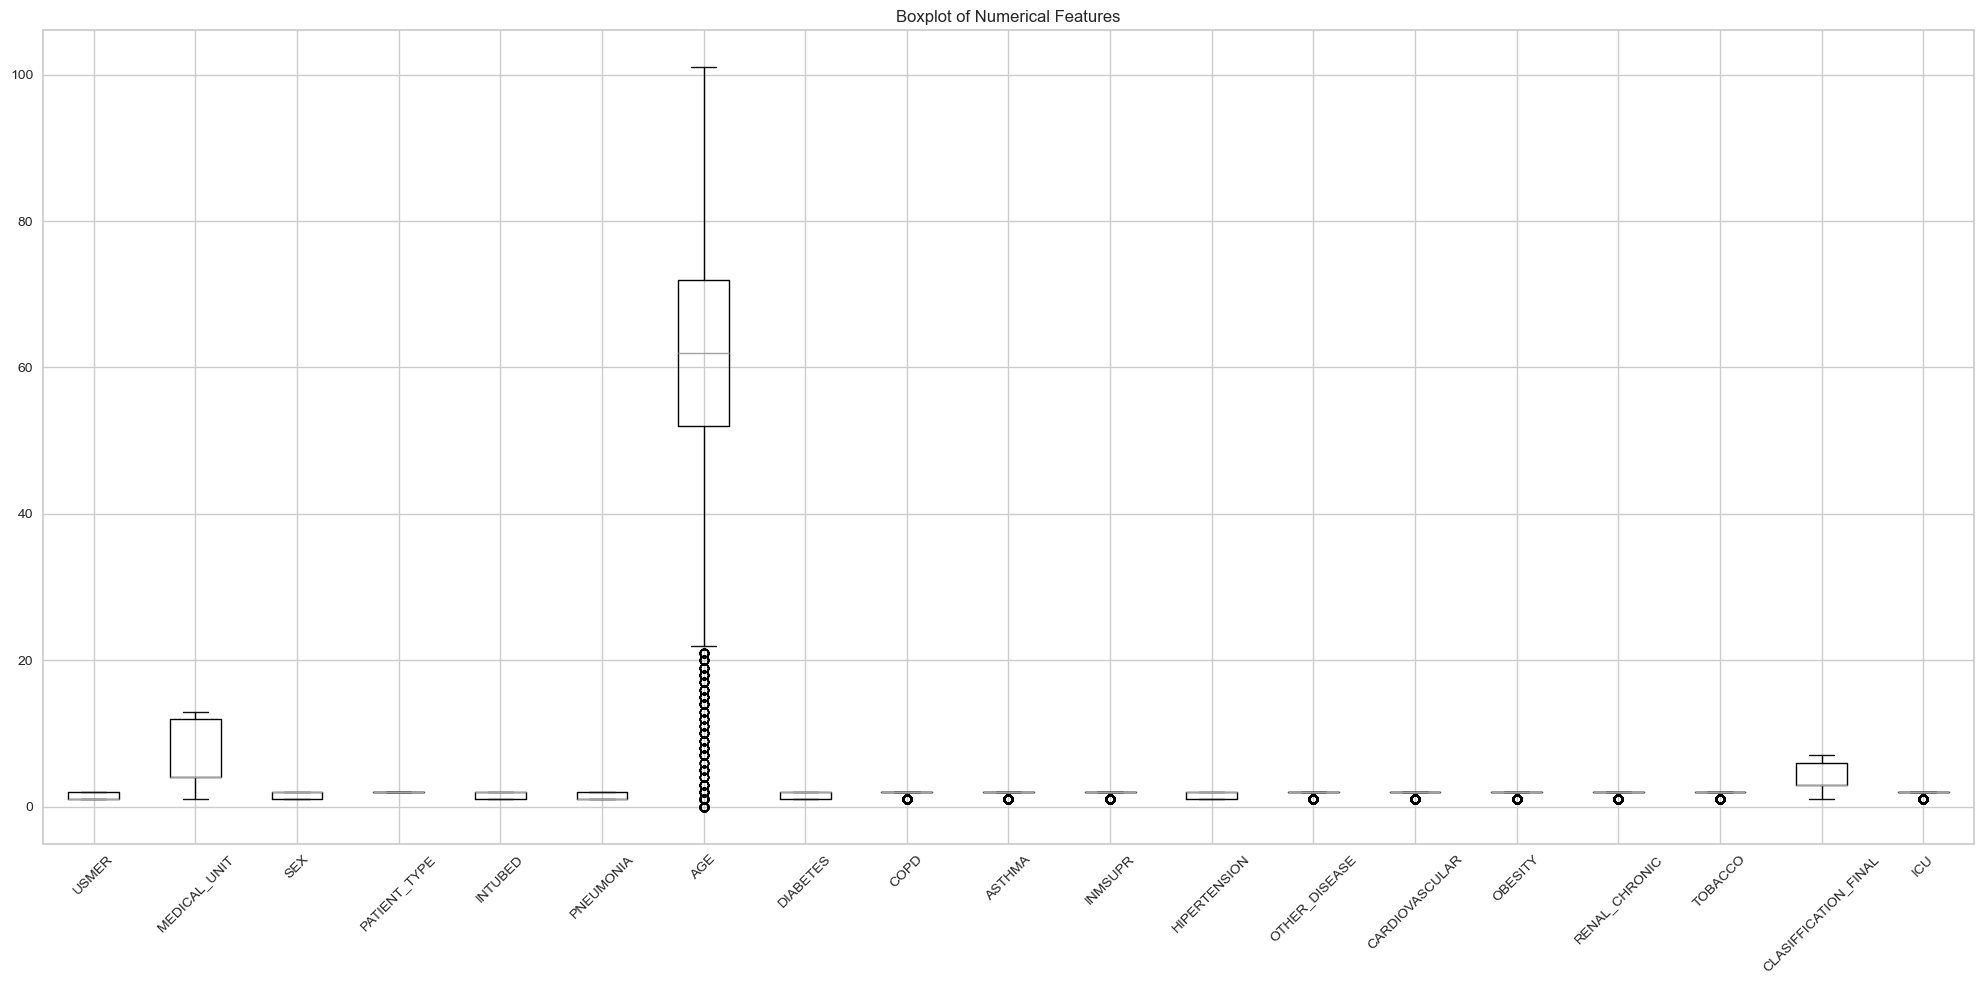

In [230]:
# Identify Potential Outliers
# Plot boxplots for numerical features
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(20, 10))
df[numeric_cols].boxplot(rot=90)
plt.title("Boxplot of Numerical Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [231]:
# Remove Outliers
# Using IQR method to filter out outliers
def remove_outliers_iqr(df, cols):
    df_cleaned = df.copy()  
    for col in cols:
        Q1 = df_cleaned[col].quantile(0.25)
        Q3 = df_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_cleaned = df_cleaned[(df_cleaned[col] >= lower) & (df_cleaned[col] <= upper)]
    return df_cleaned

df_no_outliers = remove_outliers_iqr(df, numeric_cols)
print("\nShape after removing outliers:", df_no_outliers.shape)



Shape after removing outliers: (13129, 20)


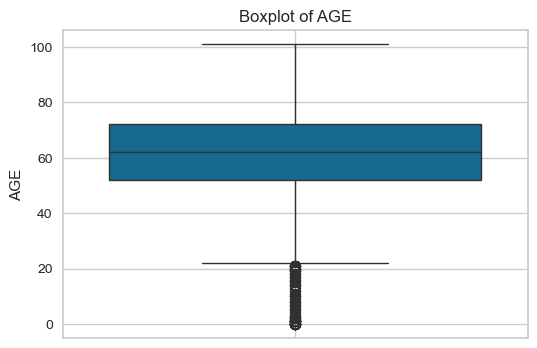

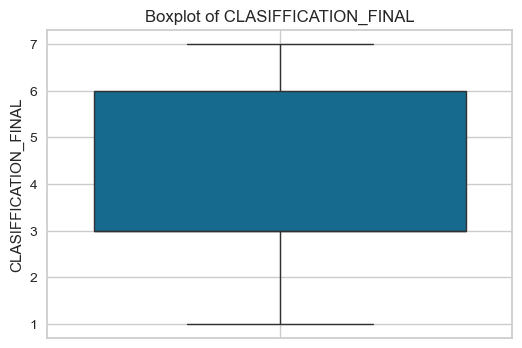

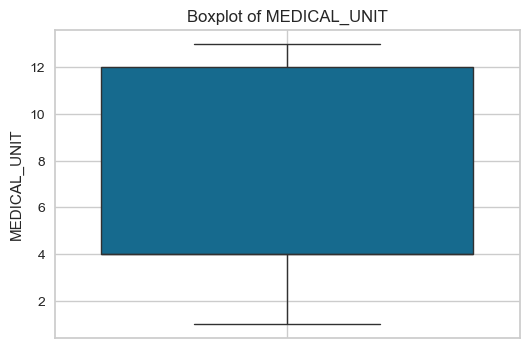

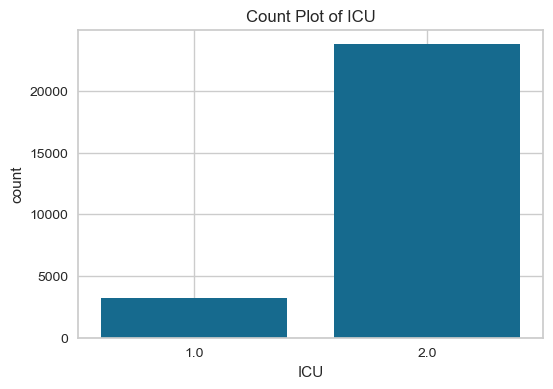

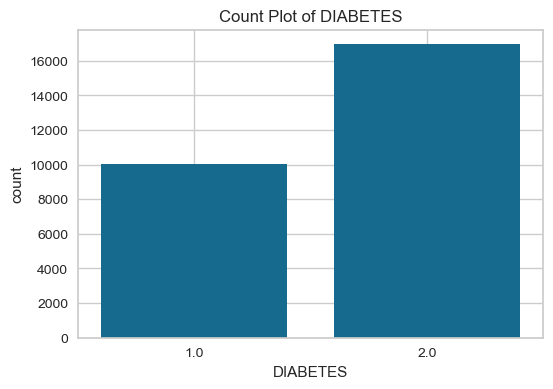

In [232]:
boxplot_cols = ['AGE', 'CLASIFFICATION_FINAL', 'MEDICAL_UNIT']
barplot_cols = ['ICU', 'DIABETES']

# 1. Boxplots for numerical features
for col in boxplot_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, y=col)
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.grid(True)
    plt.show()

# 2. Bar plots for categorical ones
for col in barplot_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col)
    plt.title(f"Count Plot of {col}")
    plt.xlabel(col)
    plt.grid(True)
    plt.show()

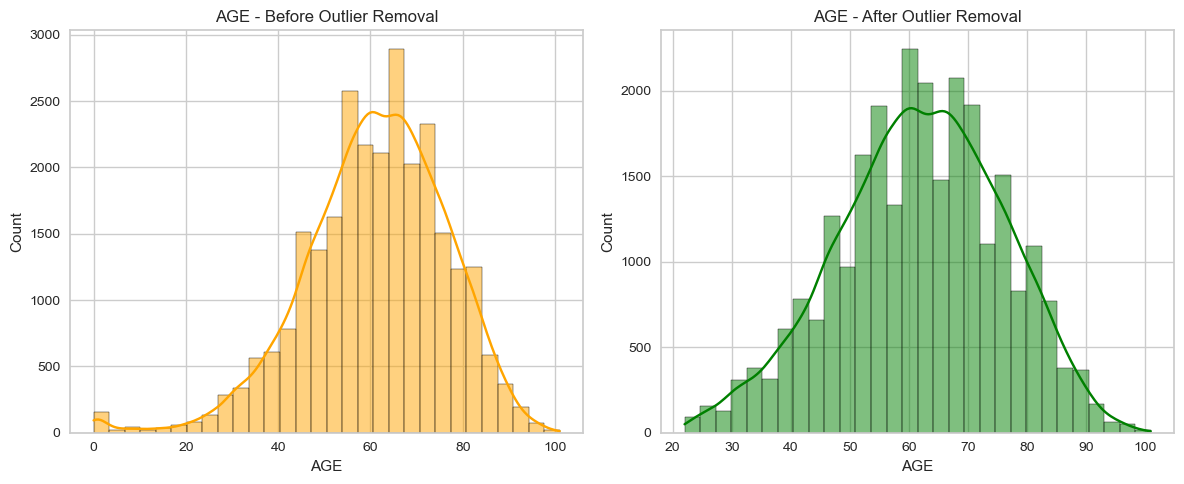

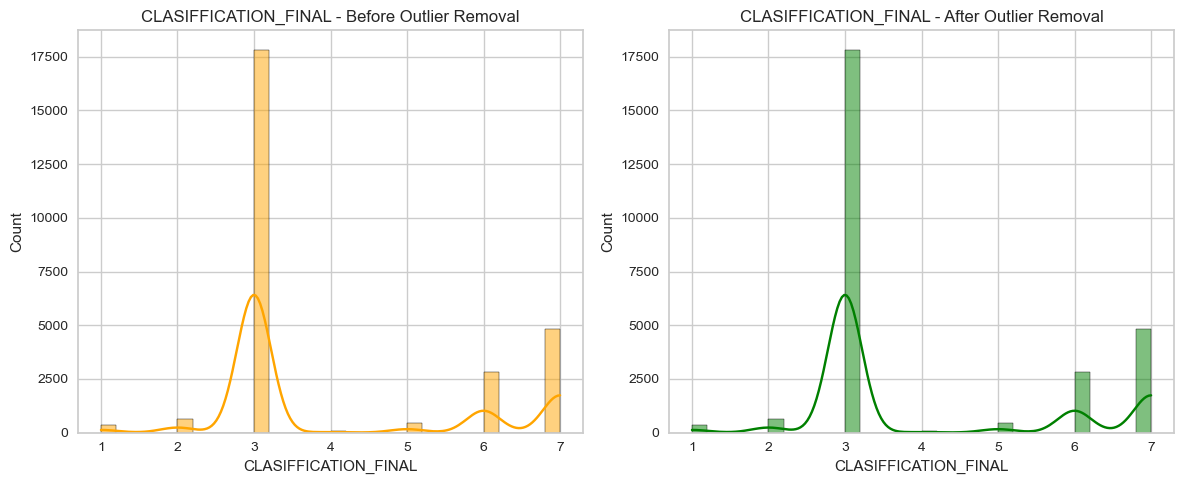


Shape after removing outliers: (26617, 20)


In [233]:
out_columns = ['AGE', 'CLASIFFICATION_FINAL']

# Plot before and after histograms
for col in out_columns:
    df_clean = remove_outliers_iqr(df, [col])  
    
    plt.figure(figsize=(12, 5))

    # Before
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=30, color='orange')
    plt.title(f"{col} - Before Outlier Removal")

    # After
    plt.subplot(1, 2, 2)
    sns.histplot(df_clean[col], kde=True, bins=30, color='green')
    plt.title(f"{col} - After Outlier Removal")

    plt.tight_layout()
    plt.show()

# Example of applying outlier removal
df_no_outliers = remove_outliers_iqr(df, ['AGE', 'CLASIFFICATION_FINAL'])
print("\nShape after removing outliers:", df_no_outliers.shape)

In [234]:
df.replace("?", np.nan, inplace=True) #replace ? values by NaN

In [235]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [236]:
print(df.dtypes)


USMER                     int64
MEDICAL_UNIT              int64
SEX                       int64
PATIENT_TYPE              int64
DATE_DIED                 int64
INTUBED                   int64
PNEUMONIA                 int64
AGE                       int64
DIABETES                float64
COPD                    float64
ASTHMA                  float64
INMSUPR                 float64
HIPERTENSION            float64
OTHER_DISEASE           float64
CARDIOVASCULAR          float64
OBESITY                 float64
RENAL_CHRONIC           float64
TOBACCO                 float64
CLASIFFICATION_FINAL      int64
ICU                     float64
dtype: object


### Final dataset shape after preprocessing.

In [238]:
print(f"final Dataset Shape: {df.shape}")

final Dataset Shape: (26978, 20)


## Task 2 : Data Visualisation

### Plot the distribution of unique classes of the target variable


Unique classes in 'ICU': [2. 1.]


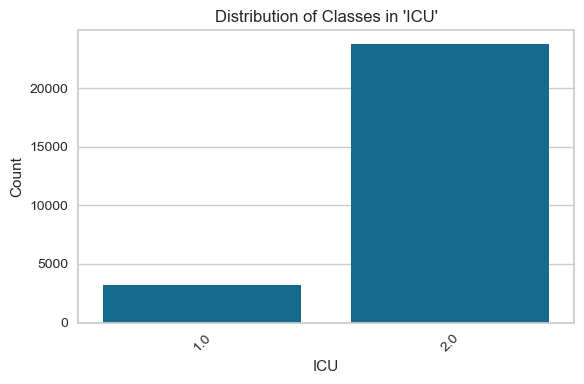


Unique classes in 'CLASIFFICATION_FINAL': [3 7 5 4 6 2 1]


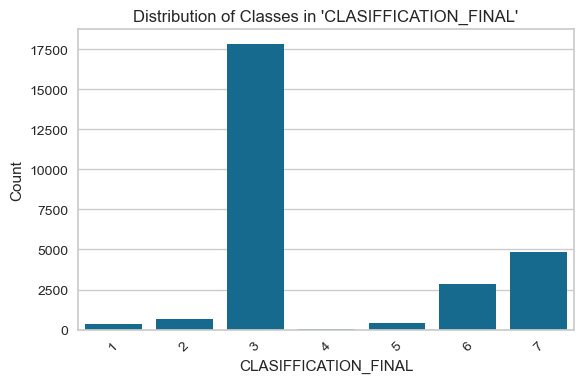

In [241]:
# List of target columns
target_cols = ['ICU', 'CLASIFFICATION_FINAL']  

# Loop through each target variable
for target in target_cols:
    # Print unique classes
    print(f"\nUnique classes in '{target}': {df[target].unique()}")

    # Plot distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x=target, data=df)
    plt.title(f"Distribution of Classes in '{target}'")
    plt.xlabel(target)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Plot the count of number of ICU cases against age.

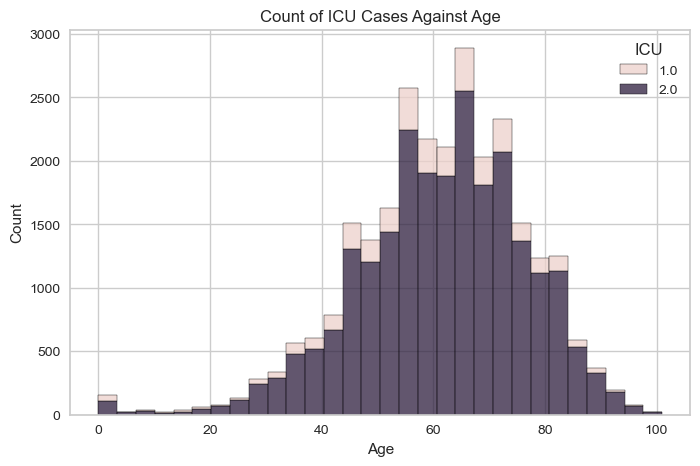

In [243]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='AGE', hue='ICU', multiple='stack', bins=30)
plt.title("Count of ICU Cases Against Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

### Plot a graph that displays the count of target variable against ‘CLASIFFICATION_FINAL’

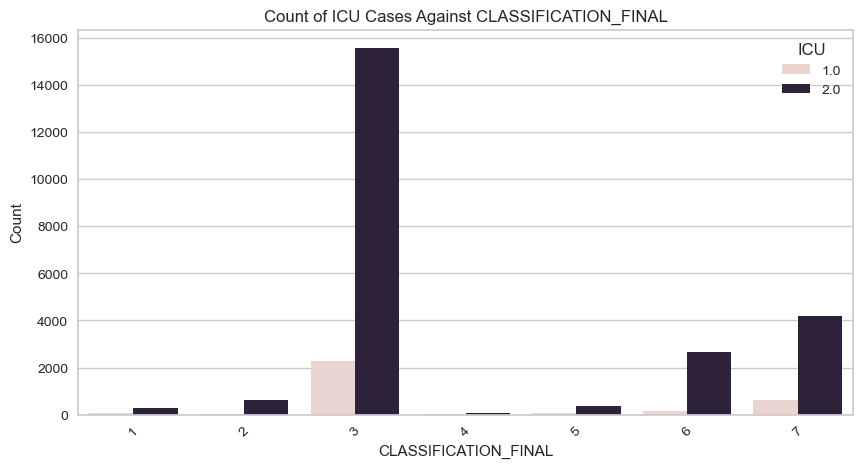

In [245]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='CLASIFFICATION_FINAL', hue='ICU')
plt.title("Count of ICU Cases Against CLASSIFICATION_FINAL")
plt.xlabel("CLASSIFICATION_FINAL")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

### Show the scatter matrix plot and the correlation matrices. Can you identify pairs of highly correlated features.

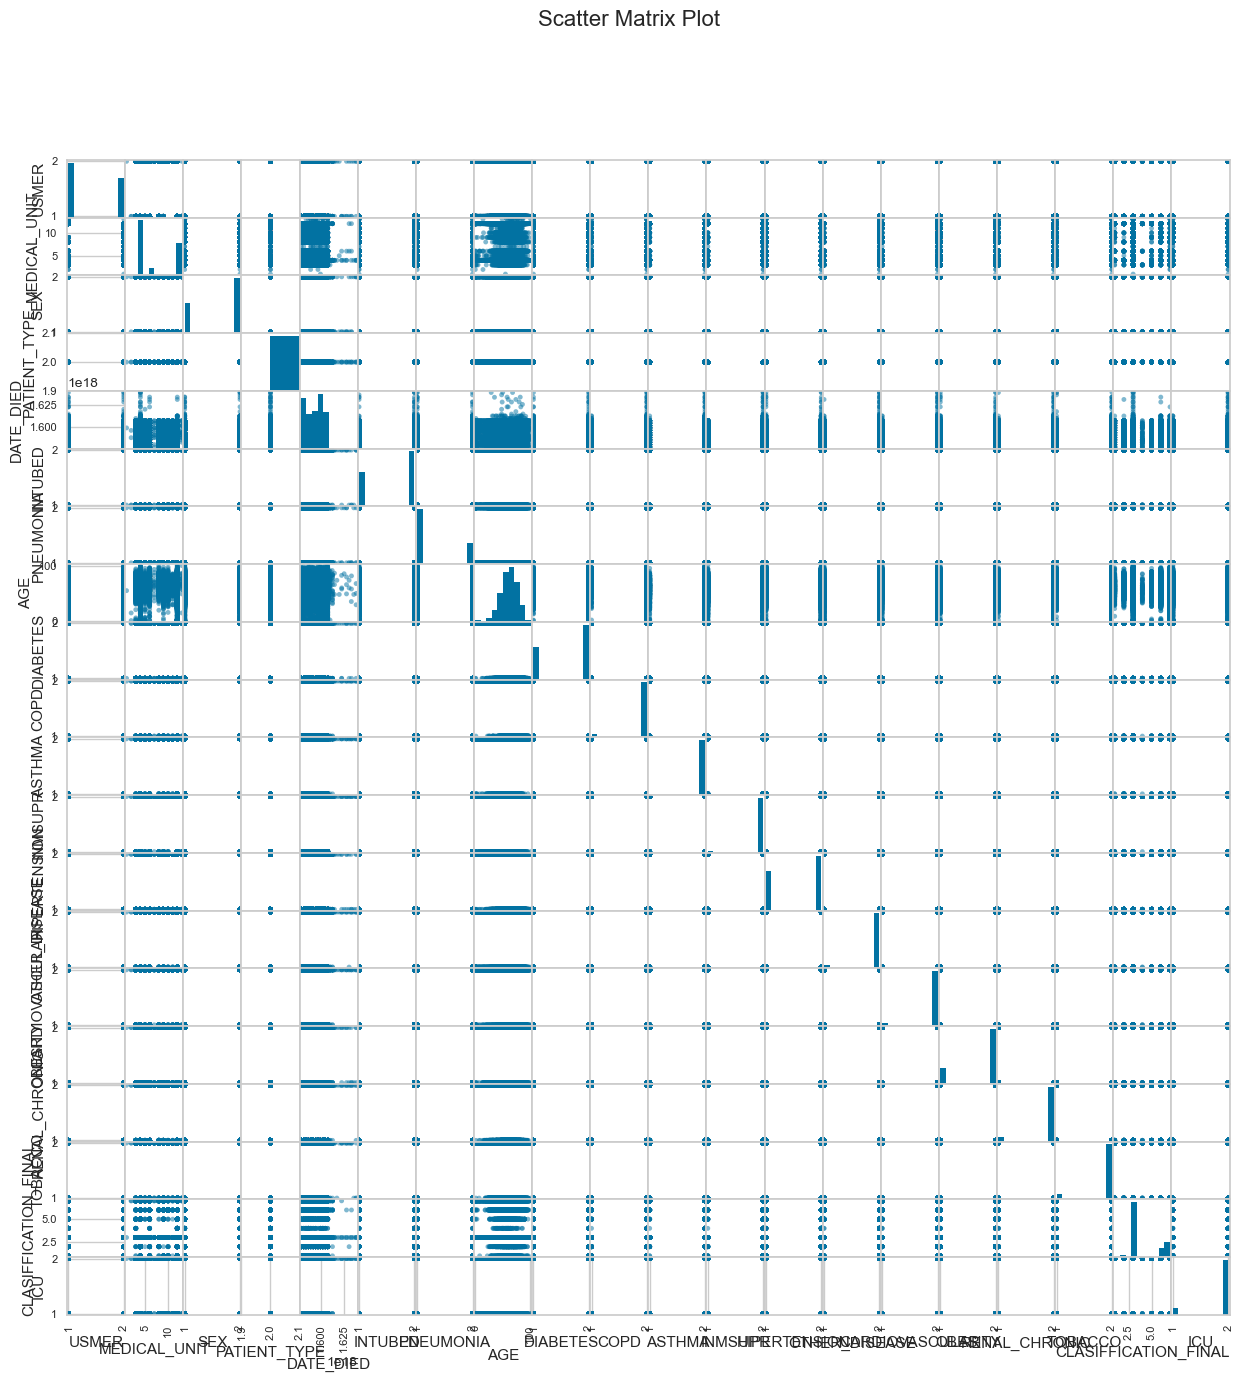

In [247]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

# Drop non-numeric columns for correlation analysis
df_numeric = df.select_dtypes(include=['number'])

scatter_matrix(df_numeric, figsize=(15, 15), diagonal='hist')
plt.suptitle("Scatter Matrix Plot", fontsize=16)
plt.show()


In [248]:
# Correlation Matrix
correlation_matrix = df_numeric.corr()
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                         USMER  MEDICAL_UNIT       SEX  PATIENT_TYPE  \
USMER                 1.000000     -0.034471  0.009209           NaN   
MEDICAL_UNIT         -0.034471      1.000000  0.031111           NaN   
SEX                   0.009209      0.031111  1.000000           NaN   
PATIENT_TYPE               NaN           NaN       NaN           NaN   
DATE_DIED            -0.007893     -0.013346 -0.006469           NaN   
INTUBED              -0.030807      0.050597 -0.016523           NaN   
PNEUMONIA             0.054614     -0.289742 -0.012260           NaN   
AGE                  -0.006807     -0.109888 -0.059885           NaN   
DIABETES              0.011183      0.022540  0.083821           NaN   
COPD                  0.004524      0.023967  0.056964           NaN   
ASTHMA                0.000308      0.005014  0.048471           NaN   
INMSUPR              -0.003795      0.033884  0.035827           NaN   
HIPERTENSION          0.015042      0.082920

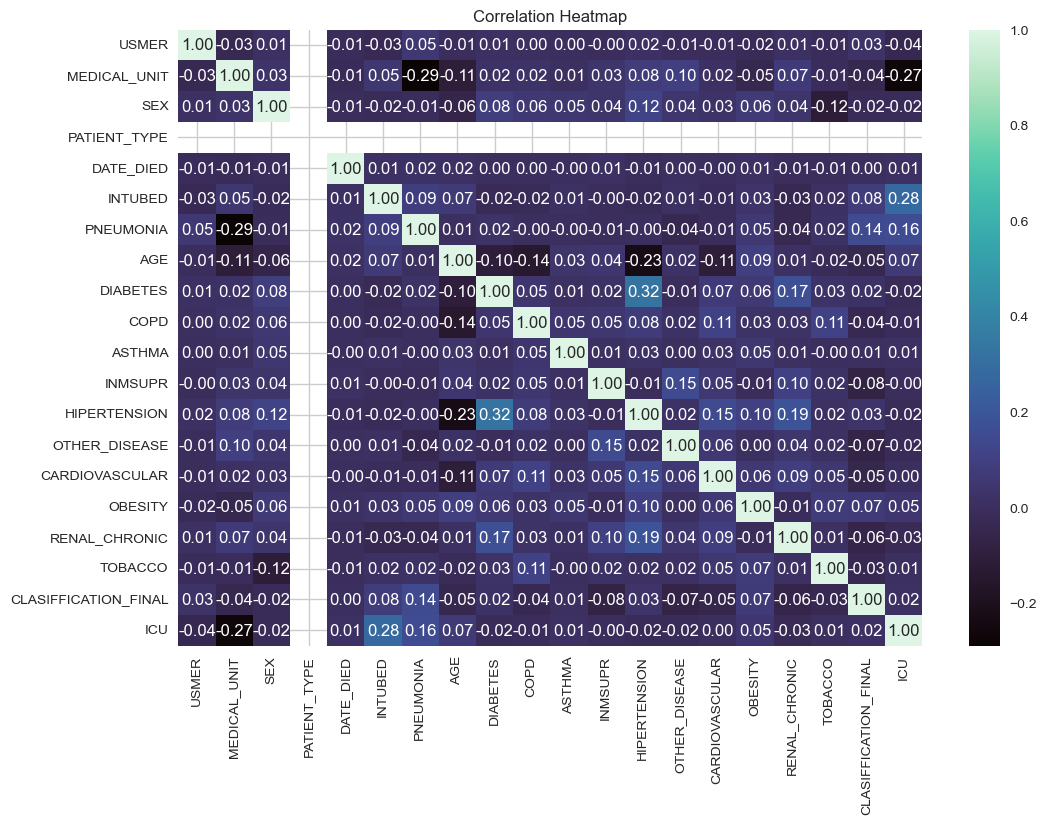

In [249]:
# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='mako')
plt.title("Correlation Heatmap")
plt.show()

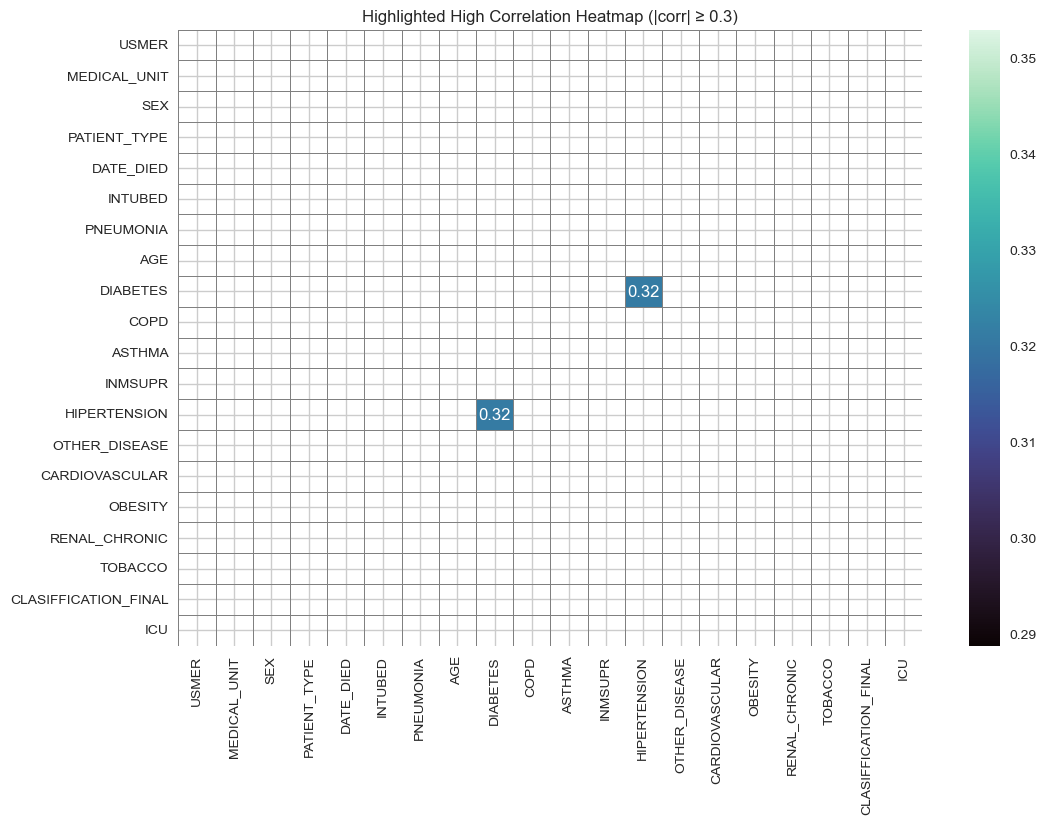

In [250]:
# Highlight High Correlation in Heatmap
plt.figure(figsize=(12, 8))
mask = (abs(correlation_matrix) >= 0.3) & (correlation_matrix != 1.0)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='mako', mask=~mask, linewidths=0.5, linecolor='gray')
plt.title("Highlighted High Correlation Heatmap (|corr| ≥ 0.3)")
plt.show()

In [251]:
# Identifying highly correlated pairs
threshold = 0.3
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) >= threshold:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

# 5. Display the pairs
print("\n Highly Correlated Feature Pairs (|correlation| ≥ 0.8):")
if high_corr_pairs:
    for col1, col2, val in high_corr_pairs:
        print(f" {col1} and {col2} --> Correlation: {val:.2f}")
else:
    print("No feature pairs have correlation >= 0.8 or <= -0.8")


 Highly Correlated Feature Pairs (|correlation| ≥ 0.8):
 DIABETES and HIPERTENSION --> Correlation: 0.32


### Additional visualizations

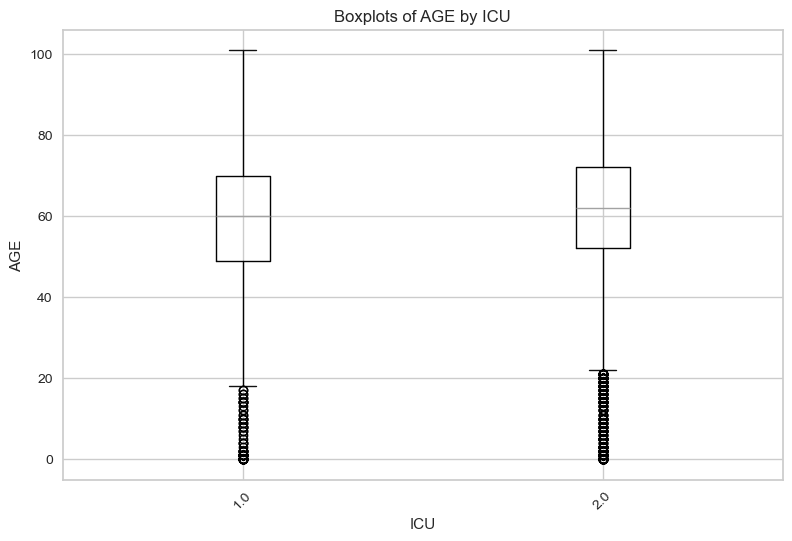

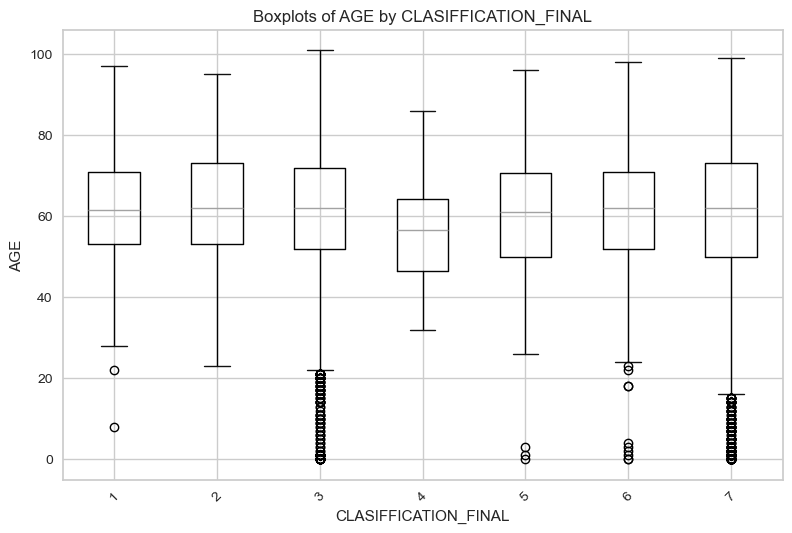

In [253]:
# Create the box plots 

def auto_boxplot(df, plot_cols, by):
    for col in plot_cols:
        fig, ax = plt.subplots(figsize=(9, 6))  
        df.boxplot(column=col, by=by, ax=ax)   
        plt.suptitle('')  
        ax.set_title(f'Boxplots of {col} by {by}') 
        ax.set_ylabel(col) 
        plt.xticks(rotation=45)
        plt.subplots_adjust(hspace=0.5)
        plt.show()

# Generate box plots for relevant columns
auto_boxplot(df, ['AGE'], 'ICU')
auto_boxplot(df, ['AGE'], 'CLASIFFICATION_FINAL')


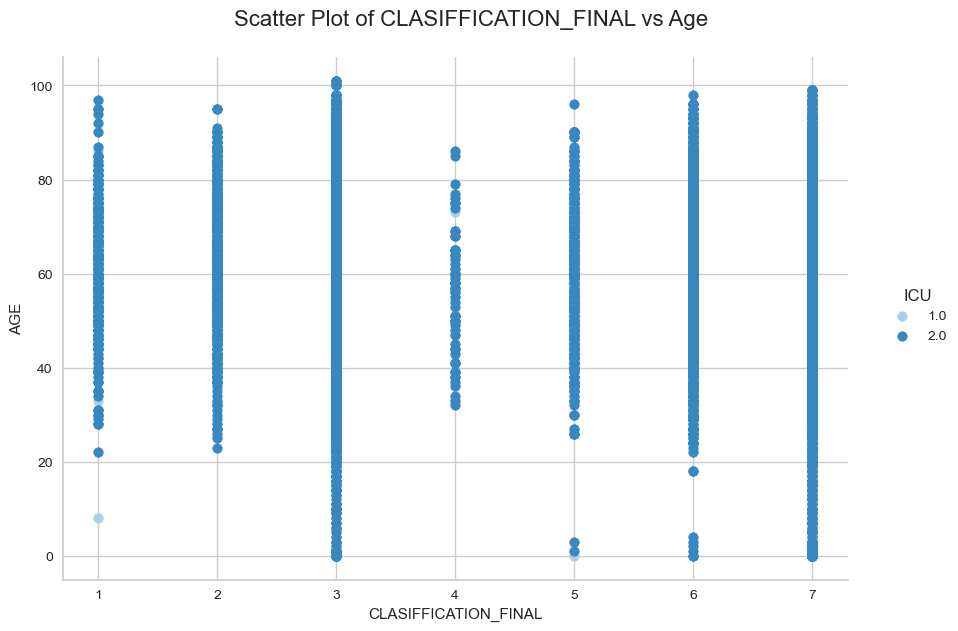

In [254]:
# Create scatter plots
def auto_scatter(df, plot_cols, hue):
    for col in plot_cols:
        g = sns.FacetGrid(df, margin_titles=True, hue=hue, palette='Blues', height=6, aspect=1.5)
        g.map(plt.scatter, col, "AGE")
        g.add_legend()
        g.fig.suptitle(f'Scatter Plot of {col} vs Age', fontsize=16, y=1.05) 
        plt.show()

# Generate scatter plots
auto_scatter(df, ['CLASIFFICATION_FINAL'], 'ICU')

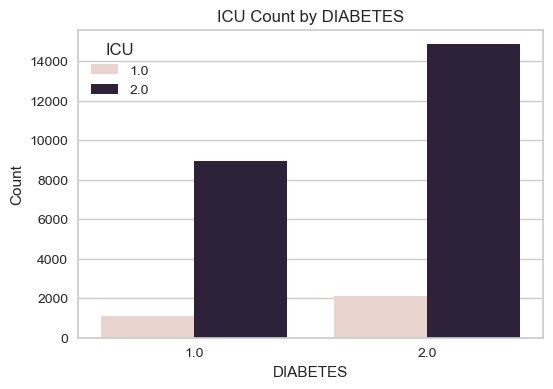

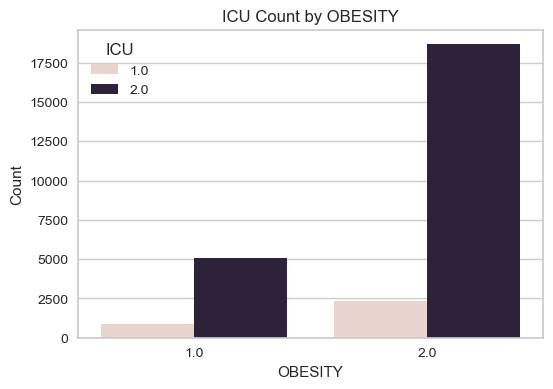

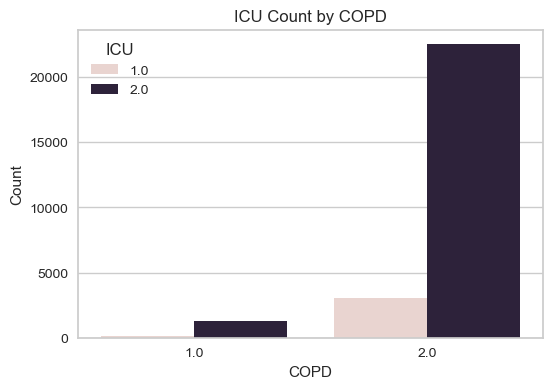

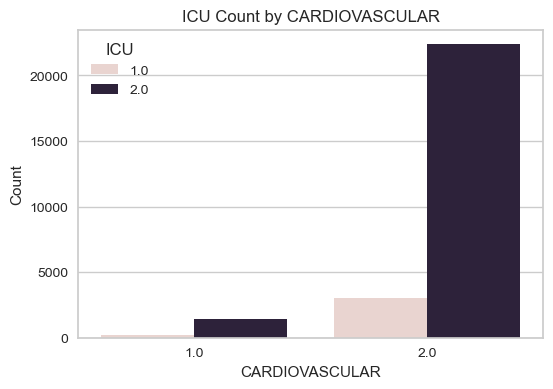

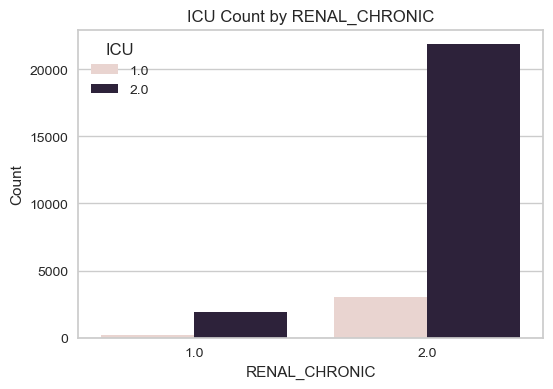

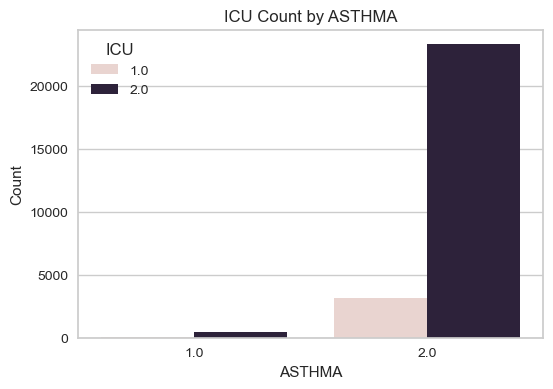

In [255]:
# List of binary comorbidity features
comorbidities = ['DIABETES', 'OBESITY', 'COPD', 'CARDIOVASCULAR', 'RENAL_CHRONIC', 'ASTHMA']

# Bar plots showing ICU vs comorbidity status
for feature in comorbidities:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=feature, hue='ICU', data=df)
    plt.title(f'ICU Count by {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='ICU')
    #plt.tight_layout()
    plt.show()


## Task 3 : Model Building


Train Accuracy: 0.8809656194977296
Test Accuracy: 0.8793550778354337
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       651
           1       0.88      1.00      0.94      4745

    accuracy                           0.88      5396
   macro avg       0.44      0.50      0.47      5396
weighted avg       0.77      0.88      0.82      5396

Precision: 0.8794
Recall: 1.0000
F1-Score: 0.9358
ROC-AUC Score: 0.5610


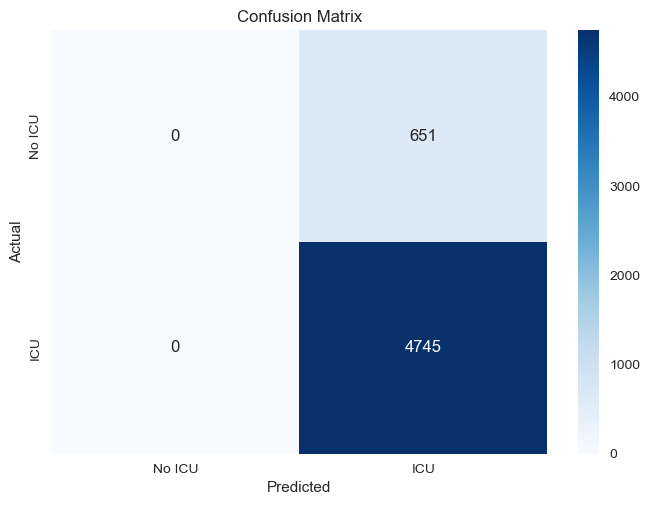

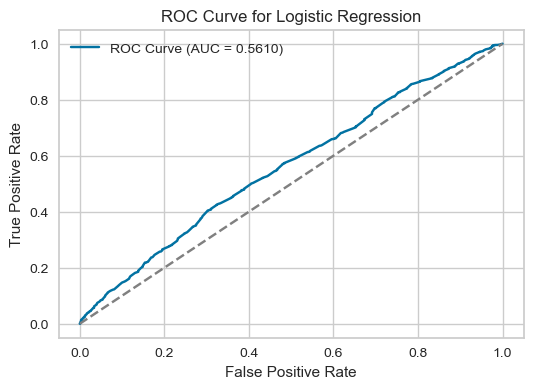

Cross-validation scores: [0.88065234 0.88065234 0.88065234 0.88063021 0.88063021]
Mean CV Accuracy: 0.8806434863019392
Standard Deviation of Scores: 1.0837474739157179e-05


In [257]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    precision_score, recall_score, f1_score, roc_curve
)
from sklearn.preprocessing import StandardScaler

# Selecting features for prediction
features = ['AGE', 'CLASIFFICATION_FINAL']  
X = df[features]
y = df['ICU'].map({2.0: 1, 1.0: 0})  # Convert ICU column to binary (ICU: 1, No ICU: 0)

# Handle missing values
X = X.dropna()
y = y.loc[X.index]

# Convert categorical variables if necessary
X = pd.get_dummies(X, drop_first=True)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] 

# Evaluate model on training and test data
y_pred = model.predict(X_test)
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)
# Print evaluation results
print("\nTrain Accuracy:", train_score)
print("Test Accuracy:", test_score)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Additional Performance Metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")


# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No ICU', 'ICU'], yticklabels=['No ICU', 'ICU'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Logistic Regression")
plt.legend()
plt.show()


# Cross-validation evaluation
cv_scores = cross_val_score(model, X, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of Scores:", cv_scores.std())

BEFORE BALANCING
Confusion Matrix:
[[4590  162]
 [ 508  136]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      4752
           1       0.46      0.21      0.29       644

    accuracy                           0.88      5396
   macro avg       0.68      0.59      0.61      5396
weighted avg       0.85      0.88      0.86      5396

ROC-AUC Score: 0.815636142742121
Cross-validated ROC-AUC Scores: [0.82057119 0.82175412 0.83006618 0.81509746 0.81480602]
Mean ROC-AUC: 0.8204589919807441

 AFTER BALANCING
Confusion Matrix:
[[494 150]
 [192 452]]

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.77      0.74       644
           1       0.75      0.70      0.73       644

    accuracy                           0.73      1288
   macro avg       0.74      0.73      0.73      1288
weighted avg       0.74      0.73      0.73      1288

ROC-AUC Score: 0.81346

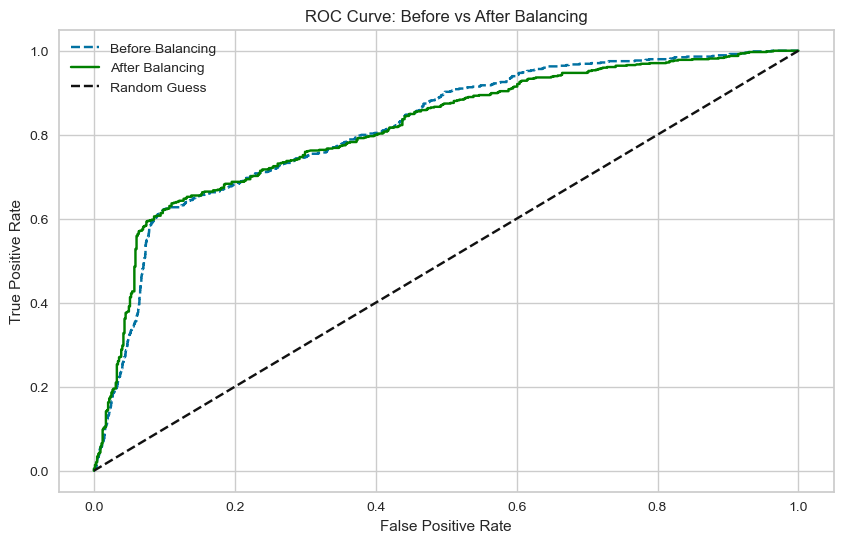


---  Summary ---
ROC-AUC (Before): 0.815636142742121
ROC-AUC (After) : 0.8134668801357973
CV AUC (Before) : 0.8204589919807441
CV AUC (After)  : 0.8209034180780064


In [258]:
# --- Imports ---
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- Data Prep ---
# Encode ICU as binary (just in case)
df['ICU'] = df['ICU'].apply(lambda x: 1 if x == 1 else 0)

# Drop non-predictive columns
X = df.drop(columns=['ICU', 'DATE_DIED', 'index'], errors='ignore')
y = df['ICU']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ------------------------  BEFORE BALANCING ------------------------

# Train/test split on imbalanced data
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
model_raw = LogisticRegression(max_iter=1000)
model_raw.fit(X_train_raw, y_train_raw)

# Predictions
y_pred_raw = model_raw.predict(X_test_raw)
y_prob_raw = model_raw.predict_proba(X_test_raw)[:, 1]

# Evaluation
print("BEFORE BALANCING")
print("Confusion Matrix:")
print(confusion_matrix(y_test_raw, y_pred_raw))
print("\nClassification Report:")
print(classification_report(y_test_raw, y_pred_raw))
print("ROC-AUC Score:", roc_auc_score(y_test_raw, y_prob_raw))

# Cross-validation
cv_scores_raw = cross_val_score(model_raw, X_train_raw, y_train_raw, cv=5, scoring='roc_auc')
print("Cross-validated ROC-AUC Scores:", cv_scores_raw)
print("Mean ROC-AUC:", cv_scores_raw.mean())

# ROC curve data
fpr_raw, tpr_raw, _ = roc_curve(y_test_raw, y_prob_raw)

# ------------------------  AFTER BALANCING ------------------------

# Combine for easy sampling
df_all = pd.DataFrame(X_scaled, columns=X.columns)
df_all['ICU'] = y.values

class_0 = df_all[df_all['ICU'] == 0]
class_1 = df_all[df_all['ICU'] == 1]

# Undersample class 0
class_0_sampled = class_0.sample(n=len(class_1), random_state=42)
df_balanced = pd.concat([class_0_sampled, class_1]).sample(frac=1, random_state=42)

X_bal = df_balanced.drop(columns='ICU')
y_bal = df_balanced['ICU']

# Train/test split (balanced)
X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation
print("\n AFTER BALANCING")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

# Cross-validation
cv_scores = cross_val_score(model, X_bal, y_bal, cv=5, scoring='roc_auc')
print("Cross-validated ROC-AUC Scores:", cv_scores)
print("Mean ROC-AUC:", cv_scores.mean())

# ROC curve data
fpr, tpr, _ = roc_curve(y_test, y_prob)

# ------------------------  ROC CURVE PLOT ------------------------

plt.figure(figsize=(10, 6))
plt.plot(fpr_raw, tpr_raw, label="Before Balancing", linestyle='--')
plt.plot(fpr, tpr, label="After Balancing", color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Before vs After Balancing")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------  Summary ------------------------

print("\n---  Summary ---")
print("ROC-AUC (Before):", roc_auc_score(y_test_raw, y_prob_raw))
print("ROC-AUC (After) :", roc_auc_score(y_test, y_prob))
print("CV AUC (Before) :", cv_scores_raw.mean())
print("CV AUC (After)  :", cv_scores.mean())


## PART 2 - IMPROVED MODEL

In [276]:
!pip install pyspark findspark
!pip install yellowbrick

# Import PySpark libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [277]:
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder.appName("CovidRiskClassification").getOrCreate()

# Load dataset
df = spark.read.csv("Dataset.csv", header=True, inferSchema=True)

# Inspect schema & first rows
df.printSchema()
df.show(5)

root
 |-- index: integer (nullable = true)
 |-- USMER: integer (nullable = true)
 |-- MEDICAL_UNIT: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- PATIENT_TYPE: integer (nullable = true)
 |-- DATE_DIED: string (nullable = true)
 |-- INTUBED: string (nullable = true)
 |-- PNEUMONIA: string (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PREGNANT: string (nullable = true)
 |-- DIABETES: string (nullable = true)
 |-- COPD: string (nullable = true)
 |-- ASTHMA: string (nullable = true)
 |-- INMSUPR: string (nullable = true)
 |-- HIPERTENSION: string (nullable = true)
 |-- OTHER_DISEASE: string (nullable = true)
 |-- CARDIOVASCULAR: string (nullable = true)
 |-- OBESITY: string (nullable = true)
 |-- RENAL_CHRONIC: string (nullable = true)
 |-- TOBACCO: string (nullable = true)
 |-- CLASIFFICATION_FINAL: integer (nullable = true)
 |-- ICU: string (nullable = true)

+-----+-----+------------+---+------------+----------+-------+---------+---+--------+--------+--

## Handling Missing Values with Imputation 

In [279]:
from pyspark.sql.functions import when

# Replace ? with None and convert all necessary columns to Integer
cols_to_clean = [
    'INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA',
    'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR',
    'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU'
]

for col_name in cols_to_clean:
    df = df.withColumn(col_name, when(df[col_name] == "?", None).otherwise(df[col_name].cast("int")))

# Drop rows where ICU is null (our label)
df = df.filter(df.ICU.isNotNull())


In [280]:
from pyspark.ml.feature import Imputer

imputer = Imputer(
    inputCols=cols_to_clean,
    outputCols=[f"{c}_imputed" for c in cols_to_clean]
)

df = imputer.fit(df).transform(df)

# Drop original cols and rename
for c in cols_to_clean:
    df = df.drop(c).withColumnRenamed(f"{c}_imputed", c)


## Feature Engineering

In [286]:
from pyspark.ml.feature import VectorAssembler

feature_cols = [
    'USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'AGE', 'INTUBED', 'PNEUMONIA',
    'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION',
    'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO'
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)


## PCA Analysis

In [289]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans(k=4, seed=42, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(df)
clustered_df = model.transform(df)

# Silhouette Score
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="cluster", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette_score_before_pca = evaluator.evaluate(clustered_df)
print("Silhouette Score (Before PCA):", silhouette_score_before_pca)


Silhouette Score (Before PCA): 0.6214187545811408


In [290]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(clustered_df)
pca_df = pca_model.transform(clustered_df)

# Silhouette Score After PCA
evaluator_pca = ClusteringEvaluator(featuresCol="pca_features", predictionCol="cluster", metricName="silhouette")
silhouette_score_after_pca = evaluator_pca.evaluate(pca_df)
print("Silhouette Score (After PCA):", silhouette_score_after_pca)

Silhouette Score (After PCA): 0.629087062464432


In [293]:
# Separate classes
high_risk_df = df.filter(df.ICU == 1)  # minority class
low_risk_df = df.filter(df.ICU == 2)   # majority class

# Undersample majority to match minority count
sampled_low_risk_df = low_risk_df.sample(withReplacement=False, fraction=16858 / 175685, seed=42)

# Combine balanced dataset
balanced_df = high_risk_df.union(sampled_low_risk_df)

# Verify class distribution
balanced_df.groupBy("ICU").count().show()


+---+-----+
|ICU|count|
+---+-----+
|  1|16858|
|  2|16830|
+---+-----+



## Comparing Random Forest and Logisitic Regression

In [296]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# Remove existing 'features' column if present
if "features" in balanced_df.columns:
    balanced_df = balanced_df.drop("features")

# Select features and label
feature_cols = [col for col in balanced_df.columns if col not in ("ICU", "index", "DATE_DIED")]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Index the label column
label_indexer = StringIndexer(inputCol="ICU", outputCol="label")

# Split the dataset
train_df, test_df = balanced_df.randomSplit([0.8, 0.2], seed=42)

### --- Random Forest Model ---
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50, maxDepth=10, seed=42)
rf_pipeline = Pipeline(stages=[assembler, label_indexer, rf])
rf_model = rf_pipeline.fit(train_df)
rf_predictions = rf_model.transform(test_df)

### --- Logistic Regression Model ---
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100)
lr_pipeline = Pipeline(stages=[assembler, label_indexer, lr])
lr_model = lr_pipeline.fit(train_df)
lr_predictions = lr_model.transform(test_df)

# Evaluators
evaluator_auc = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Random Forest Evaluation
print("📊 Random Forest Evaluation:")
print("Accuracy:", evaluator_acc.evaluate(rf_predictions))
print("F1 Score:", evaluator_f1.evaluate(rf_predictions))
print("ROC AUC:", evaluator_auc.evaluate(rf_predictions))

# Logistic Regression Evaluation
print("\n📊 Logistic Regression Evaluation:")
print("Accuracy:", evaluator_acc.evaluate(lr_predictions))
print("F1 Score:", evaluator_f1.evaluate(lr_predictions))
print("ROC AUC:", evaluator_auc.evaluate(lr_predictions))

25/04/07 10:24:47 WARN DAGScheduler: Broadcasting large task binary with size 1003.2 KiB                                                              
25/04/07 10:24:48 WARN DAGScheduler: Broadcasting large task binary with size 1660.5 KiB
25/04/07 10:24:49 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/04/07 10:24:50 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB                                                                 


📊 Random Forest Evaluation:


25/04/07 10:25:00 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


Accuracy: 0.7718202589489718


25/04/07 10:25:02 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


F1 Score: 0.7714553852822482


25/04/07 10:25:04 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


ROC AUC: 0.8552144205007348

📊 Logistic Regression Evaluation:


Accuracy: 0.7249047981721249


F1 Score: 0.7248302169443102


ROC AUC: 0.8111458343774443


# PCA analysis and Silhouette Score comparison

In [298]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import PCA, VectorAssembler, StandardScaler
from pyspark.sql.functions import col

# Start from balanced data
final_df = balanced_df  # make sure this is your balanced DataFrame

# Select numeric feature columns
feature_cols = [
    'USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'AGE',
    'CLASIFFICATION_FINAL', 'INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES',
    'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE',
    'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO'
]

# Step 1: Assemble features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(final_df)

# Step 2: Scale features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

# -------------------------
#  1. Clustering BEFORE PCA
# -------------------------
kmeans = KMeans(featuresCol="scaled_features", predictionCol="cluster_before", k=2, seed=42)
kmeans_model = kmeans.fit(scaled_df)
clustered_df = kmeans_model.transform(scaled_df)

# Evaluate Silhouette
evaluator = ClusteringEvaluator(featuresCol="scaled_features", predictionCol="cluster_before", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette_before = evaluator.evaluate(clustered_df)

print(f"Silhouette Score (before PCA): {silhouette_before:.4f}")

# -------------------------
# 2. Apply PCA
# -------------------------
pca = PCA(k=10, inputCol="scaled_features", outputCol="pca_features")
pca_model = pca.fit(scaled_df)
pca_df = pca_model.transform(scaled_df)

# -------------------------
# 3. Clustering AFTER PCA
# -------------------------
# Drop earlier cluster if needed
pca_df = pca_df.drop("cluster_before")

kmeans_pca = KMeans(featuresCol="pca_features", predictionCol="cluster_after", k=2, seed=42)
kmeans_model_pca = kmeans_pca.fit(pca_df)
clustered_pca_df = kmeans_model_pca.transform(pca_df)

# Silhouette Score (after PCA)
evaluator_pca = ClusteringEvaluator(featuresCol="pca_features", predictionCol="cluster_after", metricName="silhouette", distanceMeasure="squaredEuclidean")
silhouette_after = evaluator_pca.evaluate(clustered_pca_df)

print(f"Silhouette Score (after PCA): {silhouette_after:.4f}")

Silhouette Score (before PCA): 0.2292


Silhouette Score (after PCA): 0.2953


## Risk-Based Patient Segmentation Using K-Means Clustering and PCA

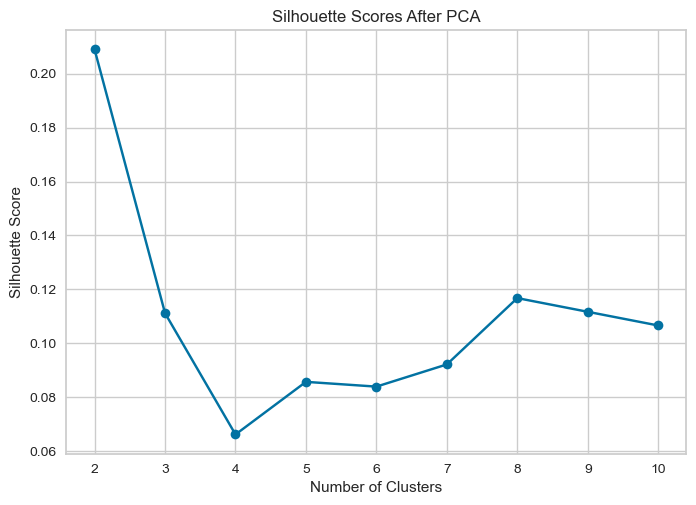

 Best K after PCA: 2
Improved Silhouette Score: 0.2090


In [301]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings("ignore")

# Apply PCA before clustering
pca_full = PCA(n_components=0.95)  # retain 95% variance
X_reduced = pca_full.fit_transform(X_scaled)

# Try clustering again on reduced data
silhouette_scores_reduced = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_reduced)
    score = silhouette_score(X_reduced, labels)
    silhouette_scores_reduced.append(score)

# Plot
plt.plot(range(2, 11), silhouette_scores_reduced, marker='o')
plt.title("Silhouette Scores After PCA")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# Best K after PCA
best_k_reduced = range(2, 11)[silhouette_scores_reduced.index(max(silhouette_scores_reduced))]
print(f" Best K after PCA: {best_k_reduced}")
print(f"Improved Silhouette Score: {max(silhouette_scores_reduced):.4f}")


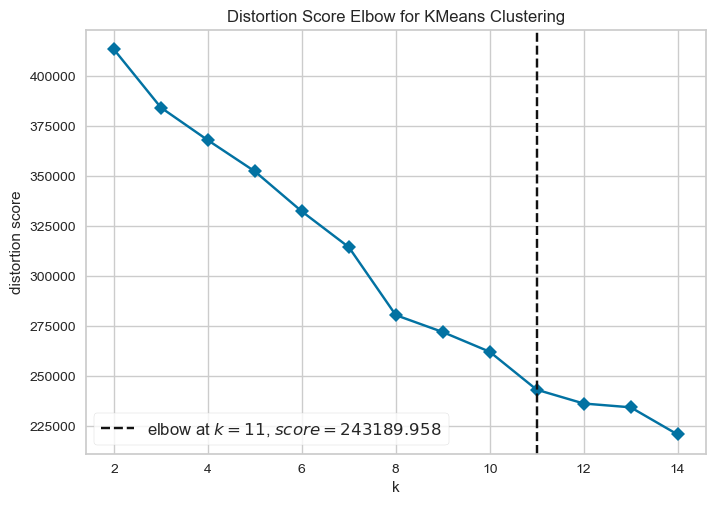

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [303]:
import warnings
from yellowbrick.cluster import KElbowVisualizer
warnings.filterwarnings("ignore", category=UserWarning)

elbow_model = KElbowVisualizer(KMeans(n_clusters=5, n_init="auto", random_state=42), k=(2, 15), metric='distortion', timings=False)
elbow_model.fit(X_reduced)
elbow_model.show()

## K-Means Clustering and Visualization

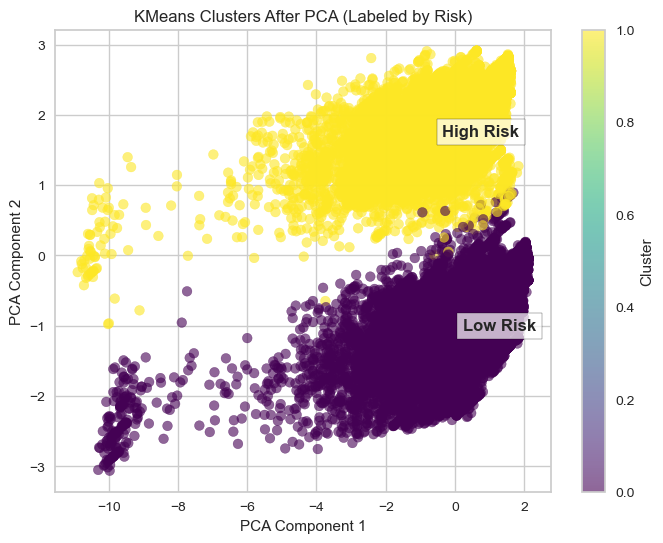

In [305]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Convert to Pandas for visualization
plot_df = clustered_pca_df.select("pca_features", "cluster_after").toPandas()

# Extract x and y from PCA features
plot_df["x"] = plot_df["pca_features"].apply(lambda v: float(v[0]))
plot_df["y"] = plot_df["pca_features"].apply(lambda v: float(v[1]))
plot_df["cluster_after"] = plot_df["cluster_after"].astype(int)

# Compute cluster centers
centroids = plot_df.groupby("cluster_after")[["x", "y"]].mean().reset_index()

# Define cluster labels based on risk (adjust based on actual feature means if needed)
cluster_labels = {0: "Low Risk", 1: "High Risk"}
plot_df["label"] = plot_df["cluster_after"].map(cluster_labels)

# Plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(plot_df["x"], plot_df["y"], c=plot_df["cluster_after"], cmap="viridis", alpha=0.6)
plt.title("KMeans Clusters After PCA (Labeled by Risk)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label="Cluster")

# Annotate cluster centers with risk labels
for _, row in centroids.iterrows():
    risk_label = cluster_labels[int(row["cluster_after"])]
    plt.text(row["x"], row["y"], risk_label, fontsize=12, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

plt.grid(True)
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

# # Convert to Pandas for visualization
# plot_df = clustered_pca_df.select("pca_features", "cluster_after").toPandas()

# # Extract x and y from PCA features
# plot_df["x"] = plot_df["pca_features"].apply(lambda v: float(v[0]))
# plot_df["y"] = plot_df["pca_features"].apply(lambda v: float(v[1]))
# plot_df["cluster_after"] = plot_df["cluster_after"].astype(int)

# # Compute cluster centers (mean x and y for each cluster)
# centroids = plot_df.groupby("cluster_after")[["x", "y"]].mean().reset_index()

# # Define custom labels
# cluster_labels = {0: "Female Patients", 1: "Male Patients"}
# plot_df["label"] = plot_df["cluster_after"].map(cluster_labels)

# # Plot
# plt.figure(figsize=(8, 6))
# scatter = plt.scatter(plot_df["x"], plot_df["y"], c=plot_df["cluster_after"], cmap="viridis", alpha=0.6)
# plt.title("KMeans Clusters After PCA (Labeled by Gender)")
# plt.xlabel("PCA Component 1")
# plt.ylabel("PCA Component 2")
# plt.colorbar(scatter, label="Cluster")

# # Annotate cluster centers with gender labels
# for _, row in centroids.iterrows():
#     gender_label = cluster_labels[int(row["cluster_after"])]
#     plt.text(row["x"], row["y"], gender_label, fontsize=12, fontweight='bold',
#              bbox=dict(facecolor='white', alpha=0.7, edgecolor='black'))

# plt.grid(True)
# plt.show()

In [ ]:
# clustered_pca_df.groupBy("cluster_after", "ICU").count().orderBy("cluster_after", "ICU").show()

In [311]:
from pyspark.sql.functions import avg
import pandas as pd

# List of columns to summarize
feature_cols = [
    'USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'AGE',
    'CLASIFFICATION_FINAL', 'INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES',
    'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE',
    'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO'
]

# Calculate averages per cluster
cluster_avgs = clustered_pca_df.groupBy("cluster_after").agg(
    *[avg(c).alias(c + "_avg") for c in feature_cols]
)

# Convert to Pandas and transpose
pdf = cluster_avgs.toPandas().set_index("cluster_after").T
pdf.columns = [f"Cluster {int(c)} Avg" for c in pdf.columns]
pdf.index = [col.replace("_avg", "") for col in pdf.index]

# Define risk-related features
risk_features = ['INTUBED', 'PNEUMONIA', 'CLASIFFICATION_FINAL', 'DIABETES',
                 'COPD', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO']

# Filter to risk features only
risk_df = pdf.loc[risk_features]

# Calculate risk score per cluster
risk_scores = risk_df.mean()

# Label clusters by risk level
high_risk_cluster = risk_scores.idxmax()
low_risk_cluster = risk_scores.idxmin()

# Rename columns accordingly
rename_dict = {
    high_risk_cluster: "High Risk Cluster Avg",
    low_risk_cluster: "Low Risk Cluster Avg"
}
pdf.rename(columns=rename_dict, inplace=True)

# Final formatted output
clean_df = pdf.reset_index().rename(columns={"index": "Feature"})
print(clean_df.to_string(index=False))

             Feature  High Risk Cluster Avg  Low Risk Cluster Avg
               USMER               1.469873              1.484125
        MEDICAL_UNIT               8.185610              8.387522
                 SEX               1.000000              1.993718
        PATIENT_TYPE               2.000000              2.000000
                 AGE              52.201693             52.585560
CLASIFFICATION_FINAL               4.625856              4.374233
             INTUBED               1.700423              1.625719
           PNEUMONIA               1.343748              1.271299
            PREGNANT               1.981839              1.000000
            DIABETES               1.669027              1.705359
                COPD               1.945671              1.955927
              ASTHMA               1.960985              1.971875
             INMSUPR               1.948980              1.959745
        HIPERTENSION               1.624933              1.685787
       OTH